In [11]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:80% !important;}</style>'))


In [20]:
''' 
This script will parse through the results folder returned from the pipeline execution and provide a list of 
the jobs that failed to complete.
Save the missing job numbers into a csv. 7361 jobs were supposed to run
'''
import os
import numpy as np
import pandas as pd

results = os.listdir('/home/toyonaga/scratch/pipeline/results')
compare = np.arange(int(input('how many jobs ran?')))

job_nums = [] #will be an int array 
for filename in results:
    try:
        start = filename.find('_') + 1 
        end = filename.find('.', start)
        job_nums.append(int(filename[start:end]))
    except:
        print('err')
        continue
print(len(job_nums))

missing = [] #list of jobs that didnt complete
for i in compare:
        if compare[i] not in job_nums:
            missing.append(compare[i])
            
print('missed this many jobs: '+ str(len(missing)))


failed = {'job':missing}

df =pd.DataFrame(data=failed)   
df.to_csv('missed_jobs.csv', index= False)

how many jobs ran? 7363


2971
missed this many jobs: 4392


In [22]:
3845 in job_nums, len(job_nums), 4392./20, 3845 in missing

(True, 2971, 219.6, False)

In [3]:
from IPython import display
import pandas as pd
import os
import time 
import subprocess
from astropy import wcs
from astropy.io import fits
from astropy.nddata.utils import Cutout2D
import numpy as np
import random
import matplotlib.pyplot as plt

DWNLD_PATH = "c_"
RESULTS_PATH = "/home/toyonaga/scratch/pipeline/results/"
start = int(input('start from this results file '))
end = int(input("end at this results file "))
CSV_PATH="test_csv" #shouldn't have to change
OUT_PATH = 'de_'#'detected_images/det_'
FP_PATH = 'fp_'#'false_postives_h2/fp_'
im_info = pd.read_csv(CSV_PATH)


def dwnld(entry): 
    subprocess.check_output(["wget", "-O",DWNLD_PATH+str(entry)+ ".fits" ,
                             "http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/"+
                             im_info['obj_name'][entry]+"_drz.fits"]) 

def get_positives(filename):
    #get coords of pred above 0.9
    crd_dict = {"ra": [], "dec":[], "obj_name":[] } 
    df = pd.read_csv(filename, sep = ',')
    for row in range(len(df)):
        if float(df['prb'][row]) > 0.999:
            crd_dict['ra'].append(df['ra'][row])
            crd_dict['dec'].append(df['dec'][row])
            crd_dict['obj_name'].append(df['obj_name'][row])
    print(len(crd_dict['ra']))
    return crd_dict
        
        

for job in range(end-start):
   
    '''populate coordinate dict with result file info'''
    try:
        crd_dict = get_positives(RESULTS_PATH+"results_"+str(job+start)+".out")
        print(len(crd_dict['ra']))
    except:
        print('missing results from job: '+str(job))
        continue
        
        
    '''download image cutouts based on the file names''' 
    fails=0
    print("dwnlding image " + str(job+start))
    #try: 
    dwnld(job+start)
    #except:
    fails+=1
    print("Failed")
    print("failed: "+str(fails))
            
        
    '''make 100x100 boxes'''
    data, hdr = fits.getdata(DWNLD_PATH + str(job+start) + ".fits", 1, header=True) #'sci' image[1] data and header
    w = wcs.WCS(hdr)
    exit=False
    for cutout in range(len(crd_dict["obj_name"])):
        try:                                

            pixcrd2 = w.wcs_world2pix([[float(crd_dict['ra'][cutout]), float(crd_dict['dec'][cutout])]], 0)
            print (pixcrd2)
            centered_cut = Cutout2D(data, (pixcrd2[0][0], pixcrd2[0][1]), (100, 100))
            print (centered_cut.shape)
            
            ims=centered_cut.data
            display.clear_output(wait=True)
            plt.imshow(ims) 
            plt.pause(0.1)
            while(1):
                ans = int(input("save=1, discard=2, exit=9"))
        
                if ans ==1:
                    fits.writeto(OUT_PATH+ str(crd_dict['ra'][cutout]) + "_" + str(crd_dict['dec'][cutout]) +'.fits',centered_cut.data, header=hdr, overwrite =True)
                    break
                if ans ==2:
                    fits.writeto(FP_PATH+ str(crd_dict['ra'][cutout]) + "_" + str(crd_dict['dec'][cutout]) +'.fits',centered_cut.data, header=hdr, overwrite =True)
                    break
                if ans ==9:
                    exit=True
                    break
            if exit==True:
                break
        except:
            print("skipped due to non-existent image, or conversion error")
    

KeyboardInterrupt: 

## 

   

## 

In [ ]:
#get probabilities to plot distributions
import pandas as pd
from astropy.io import fits
from astropy.nddata.utils import Cutout2D
import numpy as np
import os 
import time
start = time.time()
PATH = '/home/toyonaga/scratch/pipeline/results/'
crd_dict = {"prb_1": [], "prb_2":[], "prb_3":[] } 

def get_crds(full_path):
    df = pd.read_csv(full_path, sep = ',') #open results csv
    for row in range(len(df)): #for each row
        crd_dict['prb_1'].append(float(df['prb_1'][row]))
        crd_dict['prb_2'].append(float(df['prb_2'][row]))
        crd_dict['prb_3'].append(float(df['prb_3'][row]))

    return crd_dict

        
        
for filename in os.listdir(PATH):
    print(filename)
    try:
        get_crds(PATH+filename)
    except:
        print('failed to get prbs')

print(str(time.time()-start)+ " seconds ")

In [2]:
len(crd_dict['prb_1'])

20315329

In [3]:
20315329*0.002

40630.658

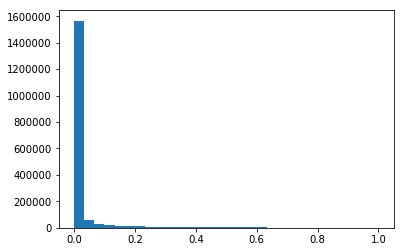

In [7]:
import matplotlib.pyplot as plt
plt.hist(crd_dict['prb_1'],30)
plt.show()


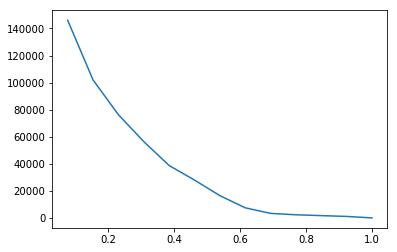

In [50]:
x_axis = np.linspace(0,1, num=14)
tens_list = [crd_dict['prb_1']]
for i in range(len(x_axis-1)):
    tens_list.append([])
    
    
def work(element,limit):
    for probability in (tens_list[element]): #check the previous percentage bin
        if probability>limit:
            tens_list[element+1].append(probability)
    return len(tens_list[element+1])

y_axis =[]
for i in range(len(x_axis-1)):
    y_axis.append(work(i,x_axis[i]))
    

plt.plot(x_axis[1:],y_axis[1:])

In [46]:
y_axis, x_axis

([1781171, 122661, 78741, 48730, 30388, 14200, 4121, 2229, 1375, 0],
 array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]))

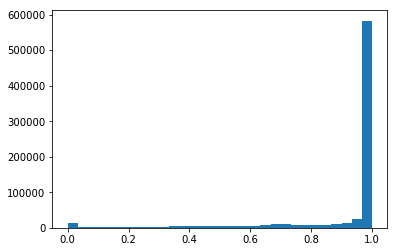

In [9]:
plt.hist(crd_dict['prb_2'],30)
plt.show()

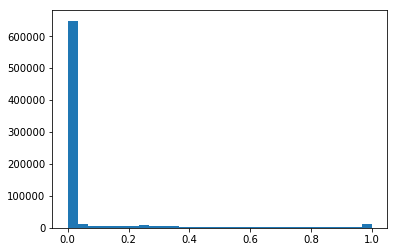

In [11]:
plt.hist(crd_dict['prb_3'],30)
plt.show()